In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import xarray as xr
import xradio
import os
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize, least_squares

# Janky imports for now
import sys
sys.path.append(os.getcwd()+"/src")

from src.calviper.base import JonesMatrix
from src.calviper.jones import GainJones
from src.calviper.visEquation import VisEquation

from toolviper.utils.data import download
from toolviper.utils.data import list_files
from toolviper.dask import local_client
import xradio.measurement_set as ms

In [3]:
if not pathlib.Path.cwd().joinpath("data/gaincaltest2.ps.zarr").exists():
    download("gaincal.test.zarr", "data")

In [4]:
viper_client = local_client(cores=4, memory_limit="4GB")

[2025-01-09 12:08:59,605]     INFO    viperlog:  Module path: /Users/nschweig/miniconda3/envs/xradio/lib/python3.12/site-packages/toolviper 
[2025-01-09 12:08:59,614]  WARNING    viperlog:  It is recommended that the local cache directory be set using the dask_local_dir parameter. 
[2025-01-09 12:09:01,805]     INFO    viperlog:  Client <MenrvaClient: 'tcp://127.0.0.1:50864' processes=4 threads=4, memory=14.90 GiB> 


In [5]:
processing_set = "data/gaincaltest2.ps.zarr"

# Full processing set
gaincal_ms = ms.open_processing_set(processing_set)
pd.set_option('display.max_rows', None)

# Get subset with calibration intents
selected_calibraters = gaincal_ms.sel(intents='CALIBRATE', string_exact_match=False)
# We select the first one to test on
# For now we select one time, channel and pol?
cal_test = selected_calibraters['gaincaltest2_0']
# These are the model visibilities?
test_vis = cal_test.VISIBILITY[0,:,0,:]

In [6]:
# Generate a Jones matrix with these visibilites
# This is a 2x2 matrix for each baseline currently
#test_jones = GainJones()
test_jones = GainJones.from_visibility(test_vis)
test_jones.matrix

<xarray.DataArray 'VISIBILITY' (baseline_id: 45, polarization: 4)> Size: 1kB
array([[ 9.64600444e-01+1.23580974e-02j,  9.46756378e-02+1.09043211e-01j,
         9.78343887e-04-1.60790324e-01j,  9.89940345e-01+2.50841200e-01j],
       [ 1.01686549e+00-1.67653158e-01j,  3.38704354e-04+4.57355306e-02j,
        -1.06121406e-01+8.16769749e-02j,  8.89374971e-01+3.56920689e-01j],
       [ 1.00011015e+00-2.83122629e-01j,  1.69153899e-01-5.10237962e-02j,
        -1.38750732e-01-1.32159218e-01j,  9.94824469e-01+4.40289706e-01j],
       [ 8.91233146e-01-2.67297536e-01j,  1.96542248e-01-6.71795569e-03j,
         1.19047962e-01+2.41207629e-02j,  6.62060440e-01+7.56019711e-01j],
       [ 7.80040681e-01-4.25314754e-01j, -3.17973308e-02-9.33948085e-02j,
        -1.03491239e-01+2.61671655e-02j,  6.05672598e-01+9.30576742e-01j],
       [ 7.09064007e-01-4.48447943e-01j, -9.60952565e-02-7.77610615e-02j,
        -7.28875678e-03-3.83319445e-02j,  5.80071986e-01+9.66363728e-01j],
       [ 7.22219229e-01-5.73931456e-01j,  1.87072396e-01-4.92925607e-02j,
         5.76175675e-02-1.10371998e-02j,  3.36665094e-01+9.21952844e-01j],
       [ 8.23426962e-01-6.75448596e-01j,  1.56945586e-01-1.22243315e-01j,
         1.03919141e-01+4.95364517e-02j,  2.62228280e-01+9.19001341e-01j],
       [ 4.77642804e-01-8.42929184e-01j,  5.51100215e-03-7.23294392e-02j,
        -4.15887199e-02+1.74904376e-01j,  1.57683149e-01+9.62884963e-01j],
       [ 8.20009232e-01-1.36521697e-01j, -5.57126924e-02+3.79943773e-02j,
        -1.41355461e-02-1.10719772e-02j,  1.05706012e+00+2.06625342e-01j],
...
         9.62444022e-02+1.33544892e-01j,  8.97244453e-01+1.33533359e-01j],
       [ 8.93239439e-01+3.65134291e-02j,  6.61959201e-02-1.39828384e-01j,
        -1.02089718e-01-9.88159254e-02j,  1.06315053e+00+2.22905457e-01j],
       [ 1.05175114e+00-2.46281609e-01j, -3.47559750e-02-7.54876733e-02j,
         1.67002399e-02+4.93572354e-02j,  6.70406044e-01+4.42072123e-01j],
       [ 9.25073922e-01-3.33101153e-01j,  3.23354378e-02-1.69529408e-01j,
         7.59285241e-02+5.49625494e-02j,  8.75622392e-01+6.19168103e-01j],
       [ 9.23959255e-01-1.44326910e-01j, -9.16287079e-02-5.43863326e-03j,
         4.42302711e-02-3.06249112e-01j,  8.96802664e-01+9.32119265e-02j],
       [ 1.00015652e+00-3.27143520e-02j,  1.17967315e-01-6.04216680e-02j,
        -1.01056255e-01-2.74846889e-02j,  9.39094841e-01+2.51556277e-01j],
       [ 7.95246899e-01-3.32076758e-01j,  1.15369387e-01-5.54800741e-02j,
        -1.65233657e-01-5.11737680e-03j,  6.56394780e-01+3.44672233e-01j],
       [ 9.57360089e-01-2.28445545e-01j,  1.20709673e-01-1.37926415e-01j,
         2.62506995e-02-3.61631848e-02j,  1.16562617e+00+2.99375560e-02j],
       [ 1.00454056e+00-3.28483880e-01j, -6.10274859e-02-3.23603712e-02j,
        -2.12135136e-01-4.56256121e-02j,  8.62321556e-01+2.23385647e-01j],
       [ 1.08736753e+00-2.10906133e-01j,  6.90343082e-02-6.89249262e-02j,
        -1.04218915e-01-7.19405562e-02j,  6.91857100e-01-6.06109435e-03j]],
      dtype=complex64)
Coordinates:
    baseline_antenna1_name  (baseline_id) <U9 2kB 'DA41_A110' ... 'DA49_A127'
    baseline_antenna2_name  (baseline_id) <U9 2kB 'DA42_A123' ... 'DA50_A108'
  * baseline_id             (baseline_id) int64 360B 0 1 2 3 4 ... 41 42 43 44
    scan_number             int64 8B 2
    time                    float64 8B 1.503e+09
    frequency               float64 8B 8.607e+10
  * polarization            (polarization) <U2 32B 'XX' 'XY' 'YX' 'YY'
Attributes:
    type:                  quanta
    units:                 ['unkown']
    field_and_source_xds:  <xarray.Dataset> Size: 152B\nDimensions:          ...

<xarray.DataArray 'baseline_id' ()> Size: 8B
array(0)
Coordinates:
    baseline_antenna1_name  <U9 36B 'DA41_A110'
    baseline_antenna2_name  <U9 36B 'DA42_A123'
    baseline_id             int64 8B 0
    frequency               float64 8B 8.607e+10
    polarization            <U2 8B 'XX'


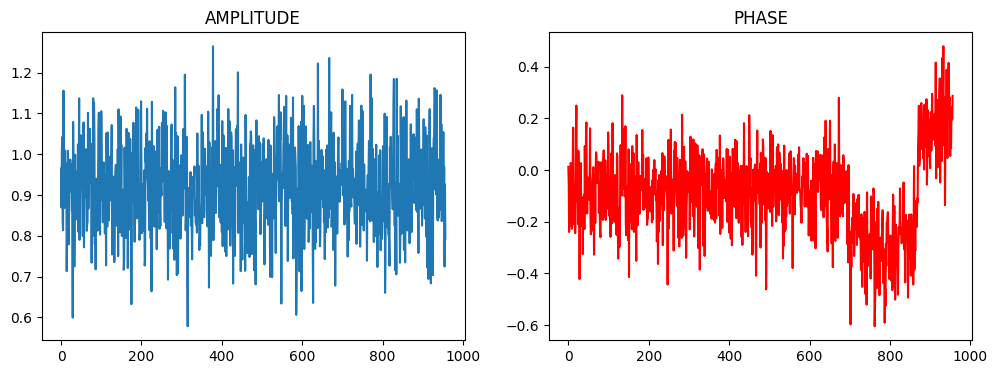

In [7]:
# Plot the XX pol model vis for one baseline for channel 0
to_plot = cal_test.VISIBILITY[:,0,0,0]
print(to_plot.baseline_id.compute())
plot_jones = GainJones.from_visibility(to_plot)

fig, axs = plt.subplots(1,2, figsize=(12, 4))
axs[0].set_title('AMPLITUDE')
axs[0].plot(np.abs(plot_jones.matrix))
axs[1].set_title('PHASE')
axs[1].plot(np.angle(plot_jones.matrix), color='r')
plt.show()


In [8]:
# Setting up the vis equation
VE = VisEquation()
VE.setSolve(test_jones)
dir(test_jones)
test_jones.type
#print(test_jones.get_type)
# Set solve won't do much do much if we don't have any apply stages
# The set_solve re-orders the pre-apply steps to fit the current type into the correct location in the order

# Make VE using the set_solve assuming reordering in the future and make solve that calls Josh's solver? 
# Attempt scipy optimize for now?

Arranging VisEquation to solve for GGainJonesMatrix


{'name': 'G', 'value': 30}

In [9]:
# We have observed visibilty for each base line
# We want antenna based gain solutions for each time (In this practice example 1 time) and each polarization
# The function we feed to the minimizer is the V_obs - J_ant1 * V_model * J_ant2^* = 0
# We need to do this for all antenna pairs and all polarizations...
# Want to avoid loops if possible?

# Fill solved gains with starting guess
# iterate over baseline pairs feed func, cur ant_1, cur_ant2, method
# repeate until satisfied? soln - last solution reaches some threshold?
# Do for each pol hand?
def solveFunc(params, vis_obs, vis_model):
    ant1 = params[:4].reshape(2,2)
    ant2 = params[4:].reshape(2,2)
    vis_model = np.asarray(vis_model).reshape(2,2)
    vis_obs = vis_obs.reshape(2,2)
    #print(ant1, vis_model)
    res = np.matmul(ant1, vis_model)
    res = np.matmul(np.conjugate(ant2), vis_model)
    return (vis_obs - res).flatten()

# for now we assume point-like source for model vis
# 1s with same shape as solve vis (make diagonal 0?)
model_vis = np.ones(np.shape(test_jones.matrix), dtype=complex)
# Make diag 0's
for i in range(len(model_vis)):
    model_vis[i][1] = 0+0j
    model_vis[i][2] = 0+0j

#print(test_jones.matrix.baseline_id.baseline_antenna1_name.to_numpy())
tes1 = (test_jones.matrix.baseline_id.baseline_antenna1_name.to_numpy())
tes2 = (test_jones.matrix.baseline_id.baseline_antenna2_name.to_numpy())

def to_vector(m1, m2):
    vec = np.hstack([m1.flatten(), m2.flatten()])
    return abs(vec)

def solve(solve_vis, model_vis=(1+0j), starting_guess=[1+0j,0+0j,0+0j,1+0j]):
    # Starting with model of 1+0j for now...
    ant1_list = solve_vis.matrix.baseline_id.baseline_antenna1_name.to_numpy()
    ant2_list = solve_vis.matrix.baseline_id.baseline_antenna2_name.to_numpy()
    solved_vals = {}
    
    # For all ants in baselines init solution to starting guess
    for i in range(len(ant1_list)):
        solved_vals.setdefault(str(ant1_list[i]), np.asarray(starting_guess))
        solved_vals.setdefault(str(ant2_list[i]), np.asarray(starting_guess))

    # iterate over all baselines and solve for gain value
    for i in range(len(ant1_list)):
        cur_val = solve_vis.matrix[i].to_numpy()
        #print(cur_val.to_numpy())
        pars = [solved_vals[ant1_list[i]], solved_vals[ant2_list[i]]]
        pars = to_vector(solved_vals[ant1_list[i]], solved_vals[ant2_list[i]])
        res = least_squares(solveFunc, pars, args=(cur_val, [1+0j,0+0j,0+0j,1+0j]))
        #print("BASELINE: ", res.x[:4].reshape(2,2), res.x[4:].reshape(2,2))
        solved_vals[ant1_list[i]] = res.x[:4]
        solved_vals[ant2_list[i]] = res.x[4:]
        

    print('---- after one iteration ----')
    for k,v in solved_vals.items():
        print(k, v)

solve(test_jones, model_vis)

/Users/nschweig/miniconda3/envs/xradio/lib/python3.12/site-packages/scipy/optimize/_numdiff.py:615: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
/Users/nschweig/miniconda3/envs/xradio/lib/python3.12/site-packages/scipy/_lib/array_api_compat/common/_aliases.py:239: ComplexWarning: Casting complex values to real discards the imaginary part
  return x.astype(dtype=dtype, copy=copy)


---- after one iteration ----
DA41_A110 [1. 0. 0. 1.]
DA42_A123 [1.22485659+0.j 0.86635282+0.j 0.96464856+0.j 2.11169307+0.j]
DA43_A115 [4.47261425+0.j 0.29483342+0.j 0.34809025+0.j 3.6740777 +0.j]
DA44_A120 [4.0724848 +0.j 1.59147449+0.j 4.34403808+0.j 4.03094831+0.j]
DA45_A091 [1.76436239+0.j 0.72409702+0.j 0.38165453+0.j 1.78700632+0.j]
DA46_A129 [3.83726017 1.5524069  3.25526239 4.05779531]
DA47_A074 [2.1464701 +0.j 2.09500206+0.j 1.63354828+0.j 1.78769933+0.j]
DA48_A070 [ 7.86152946+0.j  5.60725801+0.j 10.69750064+0.j  8.77977857+0.j]
DA49_A127 [1.41941793+0.j 0.9564369 +0.j 0.16179058+0.j 0.81050394+0.j]
DA50_A108 [ 9.15522739 +6.97125085j  1.26723508+10.10837408j
 -2.14408178+28.46281473j -2.37417984+18.15283366j]
